# Exploring Store Competition with Networks

In [91]:
# Packages
from icecream import ic 
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import nxviz as nv 

In [92]:
# Help Functions

def extract_node_type(G: nx.Graph, node_type: str):
    # Extract a particular type of node from a graph
    nodeset = [n for n, d in G.nodes(data=True) if d["node_type"] == node_type]
    if len(nodeset) == 0:
        raise Exception(f"No nodes of node_type {node_type} exist!")
    return nodeset


def plot_hbarchart(series: pd.Series, x_axis_title: str, output_path: str, percentage: bool = True):
    plt.figure(figsize=(6, 4))
    ax = series.plot(kind='barh', color='coral', edgecolor=None)

    plt.xlabel(x_axis_title)
    plt.ylabel("Shops")

    # Bar labels
    for index, value in enumerate(series):
        label = f"{value:.0%}" if percentage else f"{value:.2f}"
        ax.text(value - 0.03, index, label, 
                color='white', va='center', ha='right', fontsize=8)

    # Customize spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('lightgray')
    ax.spines['bottom'].set_color('lightgray')
    ax.tick_params(axis='both', colors='gray', labelsize=8)
    
    # Handle x-axis formatting
    if percentage:
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
        ax.set_xlim(0, 1)  # Fix x-axis range for percentages

    plt.tight_layout()

    plt.savefig(output_path, format='png', dpi=150)
    plt.show()
    plt.close()



def create_scatterplot(x_series, y_series, x_title, y_title, output_path, symmetry_line=False):
    import matplotlib.pyplot as plt
    
    # Create scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x_series, y_series, color='coral', alpha=0.9)

    # Set axis labels and title
    plt.xlabel(x_title, fontsize=10)
    plt.ylabel(y_title, fontsize=10)

    # Determine axis limits
    if symmetry_line:
        max_value = max(max(x_series), max(y_series))  # Find the highest value in either series
        plt.xlim(0, max_value * 1.1)
        plt.ylim(0, max_value * 1.1)

        # Add symmetry line
        plt.plot([0, max_value * 1.1], [0, max_value * 1.1], color='skyblue', linestyle='dotted', linewidth=2, alpha=0.6)
    else:
        plt.xlim(0, max(x_series) * 1.1)
        plt.ylim(0, max(y_series) * 1.1)

    # Customize grid and ticks
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
    plt.tick_params(axis='both', colors='gray', labelsize=8)

    # Customize spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_color('lightgray')
    plt.gca().spines['bottom'].set_color('lightgray')

    # Add labels to the scatter points using the index values
    for i, label in enumerate(x_series.index):
        plt.text(x_series.iloc[i] + 0.02, y_series.iloc[i], label, ha='left', va='center', fontsize=8, color='gray')

    # Finalize layout
    plt.tight_layout()
    plt.savefig(output_path, format='png', dpi=150)

    # Show the plot
    plt.show()
    plt.close()


## Part I: Introduction to Concepts and Application

#### Load data
Below we read the example data and transform it into nodes (with node_type customers/ shops), edges; We also add purchase_count as metadata that can be used for weights or further calculation.

Aside from the customer ID, shop ID and purchase count we also compute a metric called 'proportional_weight'. It represents the fraction of purchases a customer generated in a given shop. It is an indication of how exceptional the purchase in this shop was (i.e. 1 = 100% of purchases happened in this shop)    

In [93]:
# Load the data from the CSV
df = pd.read_csv('D:/competition_network/data/network_example.csv')

# Create an empty bipartite graph
B = nx.Graph()

# Loop through each row and calculate both the proportional weight and the absolute weight
# Group by customer to calculate the total number of purchases per customer
total_purchases_per_customer = df.groupby('customer_ID')['purchase_count'].sum()

for _, row in df.iterrows():
    customer = row['customer_ID']
    shop = row['shop_ID']
    absolute_weight = row['purchase_count']
    
    # Add "purchase_count" as edge weight 
    B.add_edge(customer, shop, absolute_weight=absolute_weight)

    # Add node type attributes
    B.nodes[customer]['node_type'] = 'customer'
    B.nodes[shop]['node_type'] = 'shop'


print("Bipartite graph created with", len(B.nodes), "nodes and", len(B.edges), "edges.")


Bipartite graph created with 27 nodes and 37 edges.


#### Visualize the Graph: Parellel & Hairball

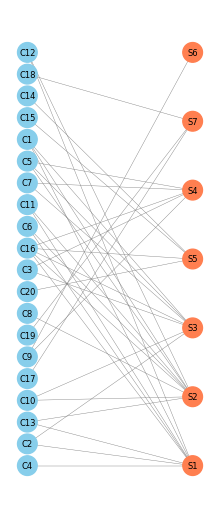

In [94]:
colors = ['skyblue' if B.nodes[node].get('node_type') == 'customer' else 'coral' for node in B.nodes]

top_nodes = {n for n, d in B.nodes(data=True) if d['node_type'] == 'customer'}  # Group 1
pos = nx.bipartite_layout(B, top_nodes)

plt.figure(figsize=(2, 5))
nx.draw(
    B, 
    pos, 
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6, 
    edge_color='gray', 
    width=0.3  # Thin edges
)


# plt.title("Undirected Bipartite Graph (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/images/bipartite_graph.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

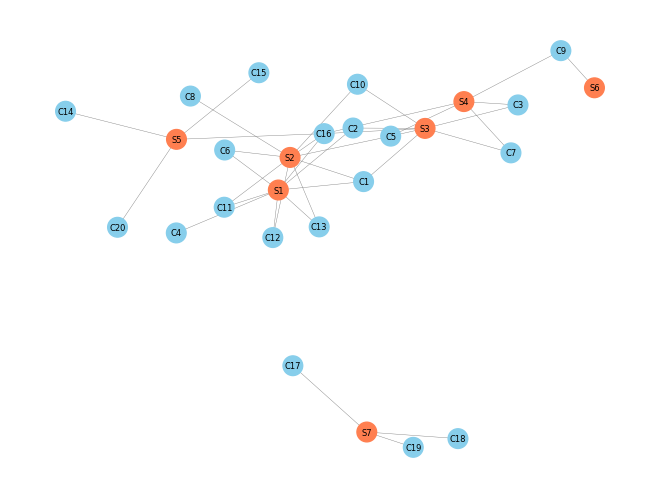

In [95]:
# Draw the graph
pos = nx.spring_layout(B, k=0.5, scale=1.5)  # Adjust 'k' for repulsion strength, 'scale' for overall size
nx.draw(B, 
    pos,
    with_labels=True, 
    node_color=colors, 
    node_size=200, 
    font_size=6,
    edge_color='gray', 
    width=0.3)

# plt.title("Hairball (Customer nodes blue | Shop nodes orange)")
# output_path = r"D:/competition_network/images/hairball.png"
# plt.savefig(output_path, format='png', dpi=150, bbox_inches='tight')

plt.show()
plt.close()

#### Projection

With ```bipartite.projected_graph(B, shop_nodes)``` function lets you create a projected graph. It makes a new graph where each node is a shop. It also makes edges between pairs of shop nodes that have at least one customer in common. Since customer nodes are turned into edges, the resulting graph only has shop nodes. 

In [96]:
# extract nodes from a particular partition
customer_nodes = extract_node_type(B, "customer")
shop_nodes = extract_node_type(B, "shop")

# compute the projection (projecting on shops)
shop_graph = bipartite.projected_graph(B, shop_nodes)

A single shared customer is enough to create an edge between two shops. However, if we would ignore the number of customers between shops, we would lose crucial information. That is, two shops that share 10 customers provide more evidence for competition than shops that have only a single customer in common. Fortunately, this information can be preserved using a weighted projection, where the number of shared customers enters the graph as an edge weight. This can be achieved with ```bipartite.weighted_projected_graph(B, shop_nodes)```.

In [97]:
weighted_shop_graph = bipartite.weighted_projected_graph(B, shop_nodes)

#### Visualize Adjacency Matrix and Circos Plot

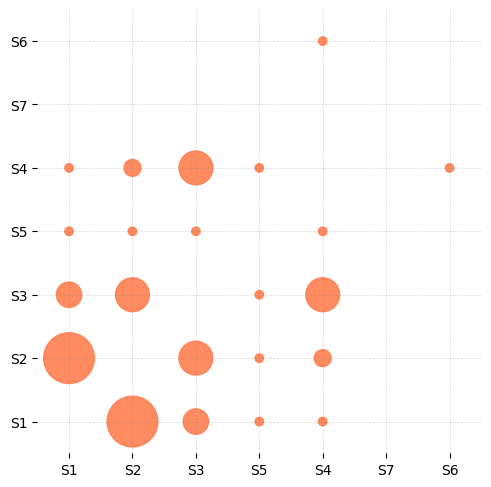

In [98]:
# Get the adjacency matrix of the weighted projected graph
adj_matrix = nx.to_numpy_array(weighted_shop_graph, weight='weight')
nodes = list(weighted_shop_graph.nodes())

fig, ax = plt.subplots(figsize=(5, 5))

# Plot each cell as a circle
for i in range(adj_matrix.shape[0]):
    for j in range(adj_matrix.shape[1]):
        weight = adj_matrix[i, j]
        if weight > 0:  # Only plot for non-zero weights
            circle = plt.Circle((j, i), radius=weight / np.max(adj_matrix) * 0.4, color='coral', alpha=0.9)
            ax.add_artist(circle)


ax.set_xticks(range(len(nodes)))
ax.set_yticks(range(len(nodes)))
ax.set_xticklabels(nodes)
ax.set_yticklabels(nodes)

ax.set_xlim(-0.5, len(nodes) - 0.5)
ax.set_ylim(-0.5, len(nodes) - 0.5)
ax.set_aspect('equal')
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()

# plt.title("Adjacency Matrix with Circles Representing Weights")
# output_path = r"D:/competition_network/images/circle_adjacency_matrix.png"
# plt.savefig(output_path, format='png', dpi=150)
plt.show()

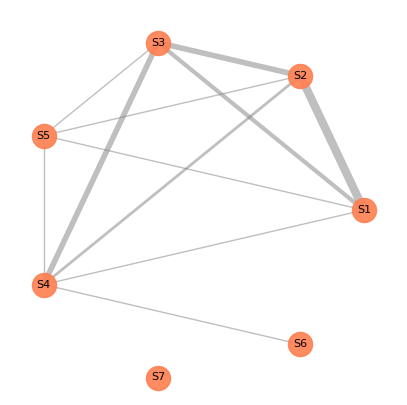

In [99]:
# Get positions for nodes in a circular layout
pos = nx.circular_layout(weighted_shop_graph)
# Get edge weights
weights = [weighted_shop_graph[u][v]['weight'] for u, v in weighted_shop_graph.edges()]


plt.figure(figsize=(5, 5))
ax = plt.gca()

nx.draw_networkx_nodes(weighted_shop_graph, pos, node_size=300, node_color='coral', alpha=0.9)
nx.draw_networkx_edges(weighted_shop_graph, pos, width=weights, edge_color='gray', alpha=0.5) 
nx.draw_networkx_labels(weighted_shop_graph, pos, font_size=8, font_color='black')
plt.axis('off')

# plt.title("Circos Plot of Weighted Projected Graph")
# output_path = r"D:/competition_network/images/circos_weighted_projection.png"
# plt.savefig(output_path, format='png', dpi=150)

plt.show()

## Part I: Introduction to Concepts and Application

### Key Metrics
Network analytics offers numerous tools and metrics. To achieve our goal of quantifying competitive intensity, we need to think about the observable patterns competition might produce in a graph. Here is a list of the most obvious characteristics a highly contested shop 'X' might exhibit:

- Low share of wallet: A low average share of wallet as result of having few unshared customers, and shared customers that buy mostly at competitors.
- Few loyal customers: A high fraction of shared customers relative to its total customer base.
- Intense direct competition: X has many direct competitors.
- Intense indirect competition: X is member of of densely connected competitor cluster, increasing localized competitive pressure.
- Submission: Important competitors have a high average share of wallet and much larger customer base, relative to X's own customer base.

This list is guided by intuition and is by no means exhaustive or grounded in theory. It provides a starting point for building and selecting metrics that we can then test against our data.

### Low Share of Wallet

We define share of wallet as the proportion of purchases made by customer C in shop S / by all purchases of customer C. Thus, if share of wallet exceeds 0.5, the customer made the majority of purchases in shop S. If we average the proportion for all customers of a shop, it tells us something about the loyality of the client base i.e. values approach 1 represent very high loyality. 

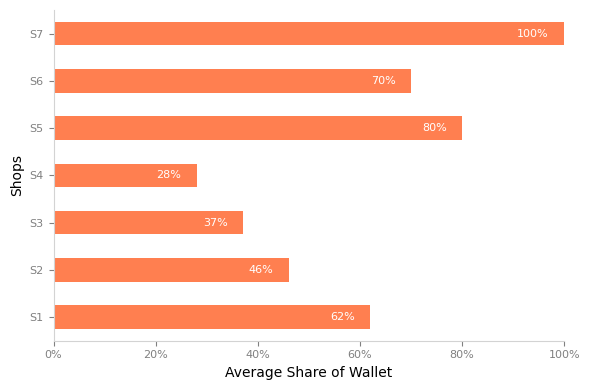

In [100]:
# Add share_of_wallet to each row in the DataFrame
total_purchases_per_customer = df.groupby('customer_ID')['purchase_count'].sum()
df['share_of_wallet'] = df['purchase_count'] / df['customer_ID'].map(total_purchases_per_customer)


# Assign share_of_wallet as an edge attribute in the bipartite graph
for _, row in df.iterrows():
    customer = row['customer_ID']
    shop = row['shop_ID']
    share_of_wallet = row['share_of_wallet']
    if B.has_edge(customer, shop):
        B[customer][shop]['share_of_wallet'] = share_of_wallet


 
# Define a function that calculates the AVG share of wallet
def get_avg_share_of_wallet(G: nx.Graph, node_set: list, weight_col: str):

    avg_share_of_wallet = {}

    for n in node_set:
        sum_of_weights = 0
        count_of_edges = 0
        
        for n1, n2, d in G.edges(n, data=True):  
            sum_of_weights += d[weight_col]
            count_of_edges += 1
        
        average_weight = sum_of_weights / count_of_edges if count_of_edges > 0 else 0
        avg_share_of_wallet[n] = average_weight

    return pd.Series(avg_share_of_wallet, name= "AVG_SHARE_OF_WALLET").sort_index()

# Create a series with AVG share of wallet per shop 
avg_share_of_wallet = get_avg_share_of_wallet(B, shop_nodes, 'share_of_wallet')

# Create h bar chart
plot_hbarchart(avg_share_of_wallet, "Average Share of Wallet", r"D:/competition_network/images/share_of_wallet.png", percentage=True)


### Few Loyal Customers

This measure is simply the number of shared customers (that bought at 2+ stores) per store divided by the total number of customers of a store.

In [101]:
def get_distinct_customers(G:nx.Graph, shop_nodes):
    dist_customers = {}
    for shop_node in shop_nodes:
        dist_customers[shop_node] = len(list(B.neighbors(shop_node)))
    return  pd.Series(dist_customers, name='NBR_DIST_CUSTOMERS').sort_index()


def get_all_unshared_customers(G:nx.Graph, customer_nodes):
    return [n for n, d in G.nodes(data=True) if (n in customer_nodes) and (len(B.edges(n)) < 2)]


def get_unshared_customers(G:nx.Graph, shop_nodes: list, customer_nodes: list):
    all_shared_customers = get_all_unshared_customers(B, customer_nodes) # all shared customers regardless of the stores
    shared_cutomers_per_node = {}
    for shop_node in shop_nodes:
        node_customers =  list(B.neighbors(shop_node))
        node_shared_customers = list(set(node_customers) & set(all_shared_customers)) # intersection of stores's and shared customers
        shared_cutomers_per_node[shop_node] = len(node_shared_customers)
    return pd.Series(shared_cutomers_per_node, name="NBR_UNSHARED_CUSTOMER").sort_index()


unshared_customers = get_unshared_customers(B, shop_nodes, customer_nodes)
distinct_customers = get_distinct_customers(B, shop_nodes)

perc_unshared_customers = unshared_customers/distinct_customers

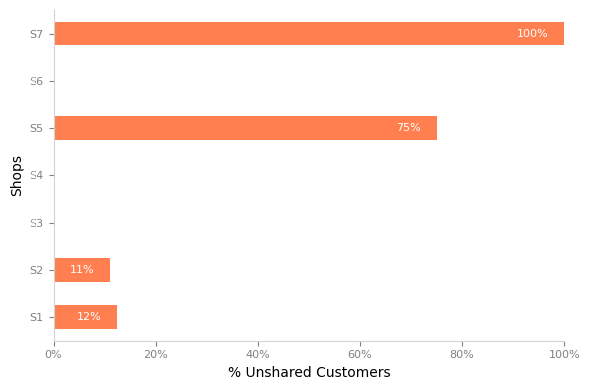

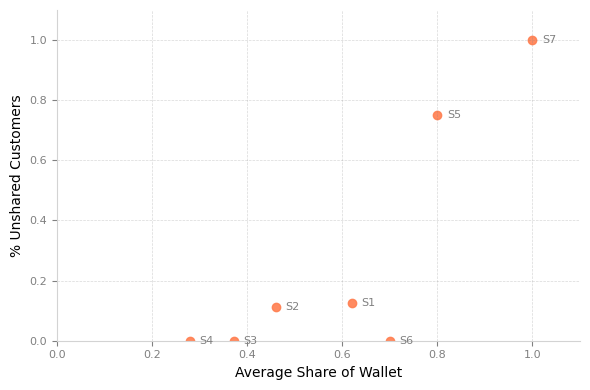

In [102]:
plot_hbarchart(perc_unshared_customers,
                    "% Unshared Customers", 
                    r"D:/competition_network/images/perc_shared_customers.png",
                    percentage=True)

create_scatterplot(avg_share_of_wallet,
                   perc_unshared_customers,
                   "Average Share of Wallet",
                   "% Unshared Customers",
                   r"D:/competition_network/images/scatter_perc_shared_cust_sow.png")

### Intense direct competition

#### Degree and Degree centrality

The number of direct competitors a store has is a solid indicator of direct competition. The simplest way to detect these is by counting the neighbours in the projected graph. This is also called the degree of a node. 

If we go one step further and normalize the degree by dividing it by the maximum possible degree in the graph (which is n−1 where n is the total number of nodes), we get to the degree centrality.  We normalize to ensure the measure lies between 0 and 1, making it comparable across graphs of different sizes. This allows for intuitive interpretation, where 1 represents maximum connectivity and 0 represents isolation.

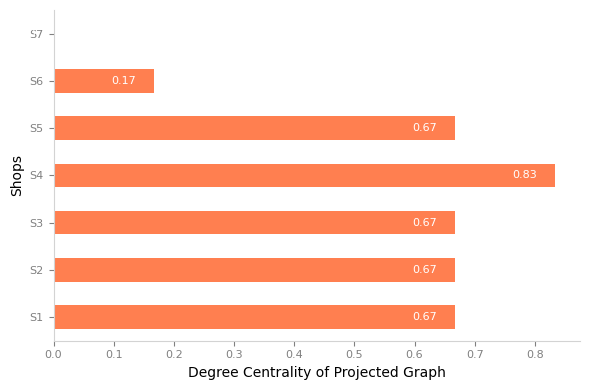

In [103]:
def get_dist_competitors(shop_graph):
    return pd.Series({n: d for n, d in shop_graph.degree()}, name="NBR_DIST_COMPETITORS").sort_index()

nbr_dist_competitors = get_dist_competitors(weighted_shop_graph) 

def get_projected_degree_centrality(G: nx.Graph):
    return pd.Series(
        nx.degree_centrality(G),
        name="PROJ_DEGREE_CENT"
        ).sort_index()

projected_degree_centrality = get_projected_degree_centrality(weighted_shop_graph)

plot_hbarchart(projected_degree_centrality,
                    "Degree Centrality of Projected Graph", 
                    r"D:/competition_network/images/projected_degree_centrality.png",
                    percentage=False)

- S7 is fully isolated. Degree centrality is therefore 0.
- We know that S6 has only a single competitor and the low degree centrality scores reflect this.
- S4 is competing with 5 out of 6 possible competitors (0.83).

#### Strength Centrality

So far, we used the amount of competitors per node, but did not consider the edge weights. Recall that when we projected the bipartite graph on the shop nodes, we used edge weights to preserve the number of customers shared between 2 store nodes. If we calculated the sum of weights, we would get the strength centrality, which emphasizes the overall competition strength over the number of competitors. Imagine, for instance, that a store is located in a popular and very touristic spot. Many people travel there, so it would accumulate many competitors from all over the country, resulting in a very high degree. However, many of its ties to competitors reflect an absolute exception because these customers only bought there during their vacations. Strength centrality would be much less impacted by the degree inflation. Upon inspection, it would become clear that, although the store has numerous competitors, many of them do not exert constant pressure on the store.

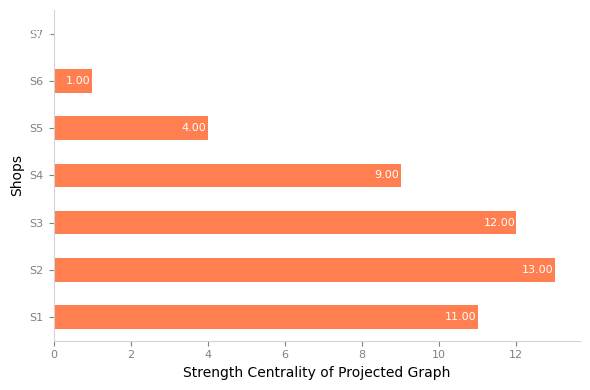

In [104]:
def get_strength_centrality(G: nx.Graph):
    strength_centrality = {
        node: sum(data['weight'] for _, _, data in G.edges(node, data=True))
        for node in G.nodes()
    }

    return pd.Series(strength_centrality, name="STRENGTH CENTRALITY").sort_index()

projected_strength_centrality = get_strength_centrality(weighted_shop_graph)

plot_hbarchart(projected_strength_centrality,
                "Strength Centrality of Projected Graph", 
                r"D:/competition_network/images/projected_strength_centrality.png",
                percentage=False)

#### Weighted degree centrality and weighted strength centrality

**Credit: Luca Candeloro, Lara Savini, Annamaria Conte**
https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0165781&type=printable#Rpone.0165781.ref023

The paper focuses on the distribution of edge weights and how it can be used to adjust degree and strength centrality. They apply a reduction factor to the degree, if a high percentage of edge weights can be assigned to a small number of edges. In our application, this will ensure we avoid overestimating the competition intensity in case of exceptional competition, like we saw for the touristic hotspot. The weighted strength centrality incorporates this correction. It is defined as their geometric mean of the weighted degree centrality and the strength centrality.

Below you find a replication of their measures and a small test with the same example data shown in the paper.

NOTE: in the paper, the WDC gets not normalized. To align with the current implementation, we will divide the wdc by n-1. 


In [105]:
# Helper function to compute the normalized weight for edge j
def compute_normalized_weight(j: int, weights: list):
    """
    Calculate the normalized weight for edge j.
    
    Parameters:
        j (int): Index of the edge (1-based).
        weights (list): List of weights for all edges.

    Returns:
        float: Normalized weight of edge j.
    """
    weights = sorted(weights)
    return weights[j - 1] / np.sum(weights)

# Function to compute the cumulative sum of normalized weights up to edge i
def cumulative_fc(i: int, weights: list):
    """
    Compute the cumulative sum of normalized weights (Fc) up to edge i.

    Parameters:
        i (int): The edge index up to which to sum (1-based).
        weights (list): List of weights for all edges.

    Returns:
        float: The cumulative Fc value for edge i.
    """
    cumulative_sum = 0
    weights = sorted(weights)
    for j in range(1, i + 1):
        cumulative_sum += compute_normalized_weight(j, weights)
    return cumulative_sum

# Function to compute the area under the curve (AUC) for the Fc values
def calculate_auc_fc(degree: int, weights: list):
    """
    Compute the AUC (area under the curve) for the cumulative Fc values.

    Parameters:
        degree (int): The degree of the node.
        weights (list): List of weights for all edges.

    Returns:
        float: The AUC value for the cumulative Fc values.
    """
    total_auc = 0
    weights = sorted(weights)
    for i in range(1, degree):  # Loop through all edges except the last
        total_auc += cumulative_fc(i, weights)
    return total_auc + 0.5  # Add 0.5 for the last AUC contribution

# Function to compute the theoretical maximum AUC for a given degree centrality
def calculate_auc_max(degree: int):
    """
    Compute the theoretical maximum AUC for a given degree.

    Parameters:
        degree (int): The degree of the node.

    Returns:
        float: The maximum possible AUC.
    """
    return degree / 2

# Function to compute the Weighted Degree Centrality (WDC)
def wdc(degree: int, weights: list):
    """
    Compute the Weighted Degree Centrality (WDC) for a node.

    Parameters:
        degree (int): The degree of the node.
        weights (list): List of weights for all edges.

    Returns:
        float: The Weighted Degree Centrality value.
    """
    # Calculate AUC for the given node
    weights = sorted(weights)
    auc_fc_value = calculate_auc_fc(degree, weights)

    # Calculate the maximum possible AUC
    auc_max_value = calculate_auc_max(degree)

    # Compute the WDC ratio and scale by degree centrality
    wdc_value = (auc_fc_value / auc_max_value) * degree
    return wdc_value


# Function to compute the Weighted Degree Centrality (WSC)
def wsc(strength_centrality: int, WDC: float):
    """
    Compute the Weighted Strength Centrality (WSC) for a node.

    Parameters:
        strength_centrality (int): The Strength Degree Centrality value.
        WDC (float): The Weighted Degree Centrality value.

    Returns:
        float: The Weighted Strength Centrality value.
    """

    return np.sqrt(strength_centrality * WDC)

# Example usage as proposed in paper
degree = 5
weights_list = [
    [20, 20, 20, 20, 20],
    [5, 10, 15, 20, 50],
    [1, 1, 96, 1, 1]]  # Example weights

for weights in weights_list:
    print(f"{weights}")
    wdc_result = wdc(degree, weights)
    print(f"    Weighted Degree Centrality: {wdc_result:.4f}")

    wsc_result = wsc(np.sum(weights), wdc_result)
    print(f"    Weighted Strength Centrality: {wsc_result:.4f}")



[20, 20, 20, 20, 20]
    Weighted Degree Centrality: 5.0000
    Weighted Strength Centrality: 22.3607
[5, 10, 15, 20, 50]
    Weighted Degree Centrality: 3.0000
    Weighted Strength Centrality: 17.3205
[1, 1, 96, 1, 1]
    Weighted Degree Centrality: 1.2000
    Weighted Strength Centrality: 10.9545


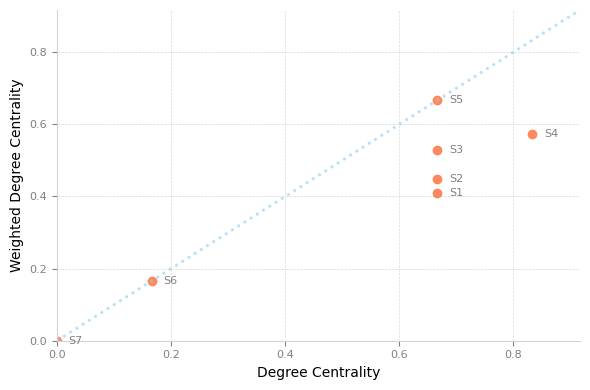

In [109]:
def get_weighted_degree_centrality(weighted_shop_graph, normalize=False):
    
    nbr_dist_competitors = get_dist_competitors(weighted_shop_graph)

    weights = {node: sorted([data['weight'] for _, _, data in weighted_shop_graph.edges(node, data=True)]) for node in weighted_shop_graph.nodes()}
    
    weighted_degree_centrality = {node: (wdc(nbr_dist_competitors[node], weights[node]) 
                                                                      if nbr_dist_competitors[node] > 0 else 0) 
                                                                for node in nbr_dist_competitors.index}
    if normalize:
        weighted_degree_centrality = pd.Series(weighted_degree_centrality) / (len(weighted_shop_graph.nodes())-1)
    
    return pd.Series(
        weighted_degree_centrality,
        name="WEIGHTED_DEGREE_CENTRALITY"
        ).sort_index()


weighted_degree_centrality = get_weighted_degree_centrality(weighted_shop_graph, normalize=True)

create_scatterplot(projected_degree_centrality,
                   weighted_degree_centrality,
                   "Degree Centrality",
                   "Weighted Degree Centrality",
                   r"D:/competition_network/images/scatter_dc_wdc.png",
                   symmetry_line=True)


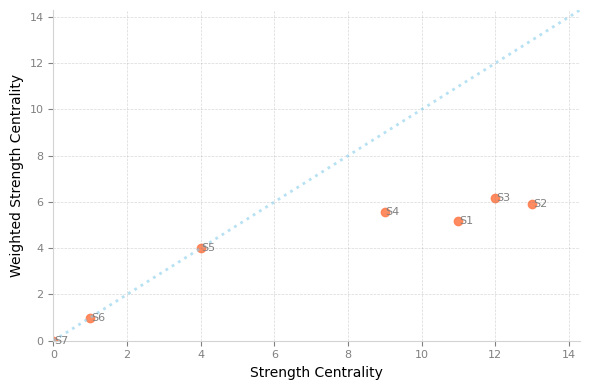

In [112]:
def get_weighted_strengths_centrality(weighted_shop_graph):
    
    strength_centrality = get_strength_centrality(weighted_shop_graph)
    weighted_degree_centrality = get_weighted_degree_centrality(weighted_shop_graph, normalize=False)
    weighted_strengths_centrality = wsc(strength_centrality, weighted_degree_centrality)
    
    return pd.Series(
        weighted_strengths_centrality,
        name="WEIGHTED_STRENGTH_CENTRALITY"
        ).sort_index()

weighted_strengths_centrality = get_weighted_strengths_centrality(weighted_shop_graph)

create_scatterplot(projected_strength_centrality,
                   weighted_strengths_centrality,
                   "Strength Centrality",
                   "Weighted Strength Centrality",
                   r"D:/competition_network/images/scatter_sc_wsc.png", 
                   symmetry_line=True)

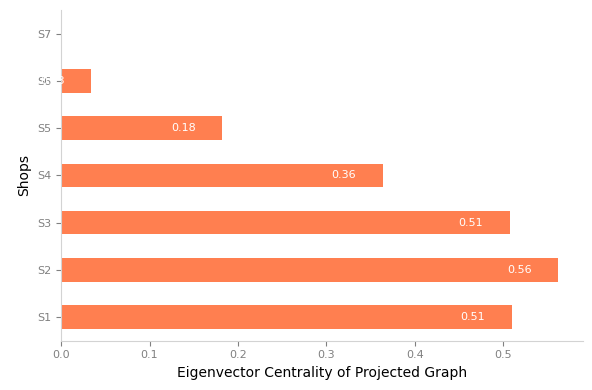

In [117]:
def get_projected_eigenvector_centrality(G: nx.Graph, weight: str = None):
    eigenvector_centrality = nx.eigenvector_centrality(G,  weight=weight)

    return pd.Series(
        eigenvector_centrality,
        name="PROJ_EIGEN_CENT"
        ).sort_index()

projected_eigenvector_centrality = get_projected_eigenvector_centrality(weighted_shop_graph, weight='weight')


plot_hbarchart(projected_eigenvector_centrality,
                "Eigenvector Centrality of Projected Graph", 
                r"D:/competition_network/images/projected_eigenvector_centrality.png",
                percentage=False)